In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_squared_error
import cv2
import random
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
import time

style.use("ggplot")
random.seed(444)

In [21]:
class model:
    
    # step is accuracy you want the model to go to
    # eg: 1 for integers, 0.1 for 1 decimal place, and 0.01 for 2 decimal places
    def __init__(self, number_of_features, dielectric_max_val, steps=False):
        self.number_of_features = number_of_features
        self.dielectric_max_val = dielectric_max_val
        self.steps = steps
        self.model = self.make_model()

    def make_model(self):
        model = Sequential()

        # if step is defined
        if self.steps:
            # input layer
            model.add(Dense(16, input_shape= (None, self.number_of_features), activation='relu'))

            # hidden layer
            model.add(Dense(32, activation='linear'))

            # output hidden layer
            model.add(Dense(int(self.dielectric_max_val * 1 / self.steps), activation='linear'))

        else:
            # input layer
            model.add(Dense(16, input_shape=(None, self.number_of_features), activation='relu'))

            # hidden layer
            model.add(Dense(32, activation='linear'))

            # output hidden layer
            model.add(Dense(self.dielectric_max_val, activation='linear'))

        # compile
        model.compile(loss="mse", optimizer='Adam')

        return model

    def fit_model(self, x_train, y_train, x_valid, y_valid,):

        # suppress warnings
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

        # fit model
        self.model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), epochs=20, verbose=0)

    def predict(self, x_test, y_test):

        # predict the test set
        y_predicted = self.model.predict(x_test)
        mse = mean_squared_error(y_test, y_predicted)
        rmse = np.sqrt(mse)

        print(f"Mean Squared Error = {mse}")
        print(f"Root Mean Squared Error(rmse) = {rmse}. The predicted dielectric constant is the actual dielectric constant +/- rmse")

        plt.plot(range(len(y_predicted)), np.argmax(y_test, axis=1), lw=0.8, color="blue", label="Actual Val")
        plt.plot(range(len(y_predicted)), np.argmax(y_predicted, axis=1), lw=0.8, color="red", label="Predicted Val")
        plt.legend()
        plt.show()

In [5]:
class players:
  def __init__(self, SIZE):
    self.SIZE = SIZE
    self.x = np.random.randint(0, self.SIZE)
    self.y = np.random.randint(0, self.SIZE)

  def pos(self):
    return (self.x, self.y)

  def movement(self, choice):
    if choice == 0:
      self.new_pos(x = 1, y = 1)
    elif choice == 1:
      self.new_pos(x = 1, y = -1)
    elif choice == 2:
      self.new_pos(x = -1, y = -1)
    elif choice == 3:
      self.new_pos(x = -1, y = 1)
    elif choice == 4:
      self.new_pos(x = 0, y = 0)
    elif choice == 5:
      self.new_pos(x = 1, y = 0)
    elif choice == 6:
      self.new_pos(x = 0, y = 1)
    elif choice == 7:
      self.new_pos(x = -1, y = 0)
    elif choice == 8:
      self.new_pos(x = 0, y = -1)

  def new_pos(self, x=False, y=False):
    if x == False:
      self.x += random.choice([-1, 0, 1])
    else:
      self.x += x
    
    if y == False:
      self.y += random.choice([-1, 0, 1]) # either -1 or 1
    else:
      self.y += y

    if self.x < 0:
      self.x = 0
    elif self.x > self.SIZE -1:
      self.x = self.SIZE -1

    if self.y < 0:
      self.y = 0
    elif self.y > self.SIZE -1:
      self.y = self.SIZE -1

In [58]:
class MyEnv:
    def __init__(self, size, enemy_p, move_p, food_r):
        self.reward = 0
        self.size = size
        self.enemy_p = enemy_p
        self.move_p = move_p
        self.food_r = food_r

        # where food, enemy, and guy are player objects
        self.enemy = players(self.size)
        self.food = players(self.size)
        self.guy = players(self.size)

        self.sub_episode = 0
        self.train_table = {'distance_from_food':[], 'distance_from_food':[], 'reward':[]}

    def reset(self):

        # reset sub episode count
        self.sub_episode = 0

        # reset CNN training table
        self.train_table = {'distance_from_food':[], 'distance_from_enemy':[], 'reward':[]}

        # resit players
        self.enemy = players(self.size)
        self.food = players(self.size)
        self.guy = players(self.size)

        dis_from_f = (self.guy.x - self.food.x, self.guy.y - self.food.y)
        dis_from_e = (self.guy.x - self.enemy.x, self.guy.y - self.enemy.y)

        return dis_from_f, dis_from_e

    def move(self, action, LIMIT_NUMBER_OF_EPISODES=False, LIMIT_NUMBER=False):
        self.sub_episode += 1
        done  = False

        if LIMIT_NUMBER_OF_EPISODES:
          if LIMIT_NUMBER:
            if self.sub_episode > LIMIT_NUMBER:
              done = True
              
          else:
            if self.sub_episode > 500:
              done = True  

        # when players move
        self.guy.movement(action)
        # self.food.new_pos()
        # self.enemy.new_pos()
        
        if self.guy.x == self.enemy.x and  self.guy.y == self.enemy.y:
          done = True
          reward = self.enemy_p

        elif self.guy.x == self.food.x and  self.guy.y == self.food.y:
          done = True
          reward = self.food_r

        else:
          reward = self.move_p * np.sqrt((self.guy.x - self.food.x)**2 + (self.guy.y - self.food.y)**2)

        distance_from_food = (self.guy.x - self.food.x) +  (self.guy.y - self.food.y)
        distance_from_enemy = (self.guy.x - self.enemy.x) +  (self.guy.y - self.enemy.y)

        future_dis_from_f = (self.guy.x - self.food.x, self.guy.y - self.food.y)
        future_dis_from_e = (self.guy.x - self.enemy.x, self.guy.y - self.enemy.y)

        self.train_table['distance_from_food'].append(distance_from_food)
        self.train_table['distance_from_enemy'].append(distance_from_enemy)
        self.train_table['reward'].append(reward)
        self.reward = reward

        return self.train_table, reward, done, future_dis_from_f, future_dis_from_e

    def view(self, show=False):
      
      done = False

      resize = 30

      guyy = 1
      foodd = 2
      enemyy = 3

      colors = {
                1: (255, 0, 0),
                2: (0, 255, 0),
                3: (0, 0, 255),  
                }

      if show:

        environment = np.zeros((self.size * resize, self.size * resize, 3))

        for i in range(self.guy.x * resize, self.guy.x * resize + resize):
                for e in range(self.guy.y * resize, self.guy.y * resize + resize):
                        environment[i][e] = colors[guyy]

        for i in range(self.food.x * resize, self.food.x * resize + resize):
                for e in range(self.food.y * resize, self.food.y * resize + resize):
                        environment[i][e] = colors[foodd]

        for i in range(self.enemy.x * resize, self.enemy.x * resize + resize):
                for e in range(self.enemy.y * resize, self.enemy.y * resize + resize):
                        environment[i][e] = colors[enemyy]                        
        
        row = [[]]
        col = []

        for i in range(self.size * resize):
            col.append([255, 255, 255])
            
        for i in range(self.size * resize + self.size + 1):
            row[0].append([255, 255, 255])

        for i in range(self.size + 1):
            environment = np.insert(environment, i * (resize + 1), col, axis=1)

        for i in range(self.size + 1):
            environment = np.insert(environment, i * (resize + 1), row, axis=0)


        cv2.imshow("", environment)

        if self.reward == self.food_r or self.reward == self.enemy_p:
          if cv2.waitKey(500) & 0xFF == ord('q'):
            done = True
        else:
          if cv2.waitKey(50) & 0xFF == ord('q'):
            done = True

      return done

In [57]:
def create_q_table(SAVED_Q_TABLE, SIZE):
  if SAVED_Q_TABLE is None:
      q_table = {}

      for x in range(-SIZE+1, SIZE):
          for y in range(-SIZE+1, SIZE):
              for x2 in range(-SIZE+1, SIZE):
                  for y2 in range(-SIZE+1, SIZE):
                      distance_from_food = (x, y)
                      distance_from_enemy = (x2, y2)
                      key = (distance_from_food, distance_from_enemy)
                      q_table[key] = [0, 0, 0, 0, 0, 0, 0, 0, 0]
  else:
      with open(SAVED_Q_TABLE, "rb") as f:
          q_table = pickle.load(f)
  
  return q_table

def create_q_table2(SAVED_Q_TABLE, SIZE):
    if SAVED_Q_TABLE is None:
        q_table = {}
        
        for dfood in range(-SIZE * 2, SIZE * 2 + 1):
            for denemy in range(-SIZE * 2, SIZE * 2 + 1):
                key = (dfood, denemy)
                q_table[key] = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    else:
        with open(SAVED_Q_TABLE, "rb") as f:
            q_table = pickle.load(f)

    return q_table

In [56]:
q_table = {'dfood': [], 'denemy': [], 0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}

for dfood in range(-SIZE * 2, SIZE * 2 + 1):
    for denemy in range(-SIZE * 2, SIZE * 2 + 1):
        q_table['dfood'].append(dfood)
        q_table['denemy'].append(denemy)
        q_table[0].append(0)
        q_table[1].append(0)
        q_table[2].append(0)
        q_table[3].append(0)
        q_table[4].append(0)
        q_table[5].append(0)
        q_table[6].append(0)
        q_table[7].append(0)
        q_table[8].append(0)
a = q_table['dfood'].index(20)
b = q_table['denemy'].index(20)
q_table[4][a+b]
# pd.DataFrame.from_dict(q_table)

0

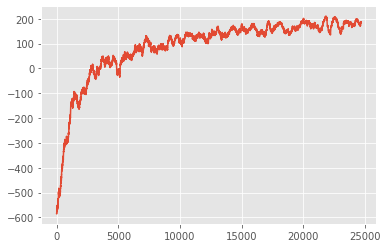

In [59]:
SIZE = 10

# episodes
EPISODES = 25_000
LIMIT_STEPS_PER_EPISODE = True
STEPS_PER_EPISODE = 200

# q table 'q_table.pickle'
# SAVED_Q_TABLE = 'q_table.pickle'
SAVED_Q_TABLE = None
SAVE = False

# epsilons
INITIAL_EPSILON = 0.8
DECAY = False
DECAY_RATE = 0.998

# penalities and reward
MOVE_P = -1
ENEMY_P = -400
FOOD_R = 300

# bell stuff
LEARNING_RATE = 0.1
GAMMA = 0.9

q_table = create_q_table(SAVED_Q_TABLE, SIZE)
rewards_list = []
env = MyEnv(10, ENEMY_P, MOVE_P, FOOD_R)

for i in range(EPISODES):
  done = False
  reward_val = 0

  dis_from_f, dis_from_e = env.reset()
  current_df_de = (dis_from_f, dis_from_e)

  while not done:

    rand_eps = np.random.random()
    if rand_eps > INITIAL_EPSILON:
        action = np.argmax(q_table[current_df_de])
        
    else:
      action = np.random.randint(0, 8)
    
    train_table, reward, done, future_dis_from_f, future_dis_from_e = env.move(action, LIMIT_STEPS_PER_EPISODE, STEPS_PER_EPISODE)

    max_future_q = np.max(q_table[(future_dis_from_f, future_dis_from_e)])
    current_q = q_table[current_df_de][action]

    if reward == FOOD_R:
      new_q = FOOD_R
    elif reward == ENEMY_P:
      new_q = ENEMY_P
    else:
      new_q = current_q * (1 - LEARNING_RATE) + LEARNING_RATE * (GAMMA * max_future_q + reward)

    q_table[current_df_de][action] = new_q
    current_df_de = (future_dis_from_f, future_dis_from_e)

    if i > 24_990 or i < 10:
      show = True
    else:
      show = False

    env.view(show)
    reward_val += reward
  rewards_list.append(reward_val)
  INITIAL_EPSILON *= DECAY_RATE

  if DECAY:
    if INITIAL_EPSILON < 0.0001:
        INITIAL_EPSILON = 0.5
    
avg = np.convolve(rewards_list, np.ones((300,))/300, mode='valid')

plt.plot([i for i in range(len(avg))], avg)

plt.show()

if SAVE:
  with open("q_table.pickle", "wb") as f:
      pickle.dump(q_table, f)

